In [202]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import pickle
import time

In [203]:
RATE_LIMIT=3
SLEEP_TIME=1
WAIT_TIME=3
MAX_PY=15  #max players recorded is 15 slot 5 is used to record score instead
SCORE_LOC=0
link_count=0
link_wait=0
FORMAT='lxml'
site_header = "https://www.basketball-reference.com"

In [204]:
'''
players={"None":{
    "name":"Reserves",
    "DOB":"1900",
    "drafted":1900,
    "gp":0,
    "team":"None",
    "link": ""}}
game_data=[]
playoff_data=[]
'''    


In [490]:
#pickle.dump(game_data,open("game_data.p","wb"))
#pickle.dump(playoff_data,open("playoff_data.p","wb"))   
#pickle.dump(players,open("players.p","wb"))   

#game_data=pickle.load(open("game_data.p","rb"))
#playoff_data=pickle.load(open('playoff_data.p','rb'))
#players=pickle.load(open("players.p","rb"))

First find line score in the page. This will produce the the first set of values.

In [205]:
def  get_response(link):    
    '''
    use request to get a page. If not ready, keep increase wait time 
    '''
    global link_wait,link_count
    link_count+=1
    if (link_count % RATE_LIMIT) == 0:
        time.sleep(SLEEP_TIME)
        print(link_count)
    if link[0] == '/':
        link=site_header + link
    #with open('test.html') as page:
    #    return page.read()
#def get(link):    
    response = requests.get(link)
    while response.status_code != 200:
        link_wait += WAIT_TIME
        time.sleep(link_wait)        
        print("Failure in opening {}, waiting {} s".format(link,link_wait))
        response = requests.get(link)
    return response.text

In [276]:
def parse_month_sch(month_soup,game_data,work):
#month_soup=sch_soup
#for k in range(0,1):  
    '''
    Parse a month worth of regular season box scores 
    If work is True, process all the lines until 
    playoff line is seen. 
    If work is False, process nothing until the playoff
    line is seen. Then start processing all lines after.
    This playoff line is only seen in April, as in
    May/June, the entire month is playoff so the line is 
    not seen.     
    '''
    
    non_playoff = True     
    # Set counter to negative to skip the first n lines if needed
    counter=0
    sch_div=month_soup.find('div',id='all_schedule')
    title=sch_div.find('h2').text
    print("Start of {}".format(title))
    month_div=sch_div.findNext('div',id='div_schedule').find('tbody')
    tr_tag=month_div.find('tr')

    while tr_tag :
        if (tr_tag.text == "Playoffs"): 
            non_playoff=False
            # the line with text "playoff" has no content. Seek next line
            tr_tag=tr_tag.findNext('tr')
            
        if (non_playoff == work):
            box_tag=tr_tag.find('td',text="Box Score")        
            box_link = box_tag.find('a').get('href')
            print(box_link.split('/')[-1])
            counter+=1
            if counter > 0:
                parse_box_score(box_link,game_data)           
            
        tr_tag=tr_tag.findNext('tr')
    print("{} done".format(title))


In [286]:
def parse_season_sch(link,game_data,playoff):
#with open('schedule.html') as page:
    #test_html = page.read()
    #sch_soup = BeautifulSoup(test_html, FORMAT)
    '''
    Parse the box score of a whole regular season season
    and save the output game data
    playoff months in May and June are skipped
    '''
        
    sch_soup = BeautifulSoup(get_response(link), FORMAT)
    sch_filter = sch_soup.find('div',id='content').find('div',class_='filter')
 
    for item in sch_filter.find_all('div'): 
        
        text=item.get('class')
        #If playoff is false, process up to April, skip the May and June schedule.
        #otherwise, only process starting from April. Half the games in April is
        #regular season, half is playoff. Send the work flag to tell if shall
        #process the playoff part, or the regular season part

        if text and ("current" in text):
            #This is October
            if playoff:
                continue
            parse_month_sch(sch_soup,game_data,True)            
        elif item.text.strip() in ['May','June']: 
            if not playoff:
                continue
            n_link=item.find('a').get('href')
            n_soup = BeautifulSoup(get_response(n_link), FORMAT)            
            parse_month_sch(n_soup,game_data,True)
        elif item.text.strip() == 'April':
            n_link=item.find('a').get('href')
            n_soup = BeautifulSoup(get_response(n_link), FORMAT)            
            parse_month_sch(n_soup,game_data,not playoff)
        elif not playoff:  
            n_link=item.find('a').get('href')
            n_soup = BeautifulSoup(get_response(n_link), FORMAT)            
            parse_month_sch(n_soup,game_data,True)
    
    if playoff:
        filename="playoff_data.p"
    else:
        filename='game_data.p'

    pickle.dump(game_data,open(filename,"wb"))
    pickle.dump(players,open("players.p","wb"))              

game_data

In [208]:
def find_box(df,soup,team,date):
    p_list=list(range(0,15))
    for i in range(1,5):
        find_q_box(df,p_list,soup,team,date,i)
    return p_list

In [209]:
def parse_box_score(link,game_data):
#for j in range(0,1):    
    '''
    parse a box score of a game
    Parse general info first, then 4 quarters of the visiting team
    box score, then 4 quarters of home team box score
    '''    
    soup = BeautifulSoup(get_response(link), FORMAT)

    #soup = BeautifulSoup(response.text, FORMAT)    
    #find the date and teams from the title.
    title = soup.find("title").text.split('Box Score')
    teams=title[0].split(' at ')
    visit=teams[0]
    home =teams[1]
    date = pd.to_datetime(title[1].split('|')[0].replace(',',''))

    #team shorthand
    teamsymbol=soup.find('div', class_='scorebox').find_all('strong')
    team_v = teamsymbol[0].find('a').get('href').split('/')[-2]
    team_h = teamsymbol[1].find('a').get('href').split('/')[-2]

    #line score per quarter.
    #line_table = soup.find('div', id="div_line_score",class_='table_container is_setup').find('tbody').find_all('tr')
    #row1 is visiting team, row2 2 is home team
    #line_v= pd.Series([ int(td.text) for td in line_table[0].find_all('td')])
    #line_h= pd.Series([ int(td.text) for td in line_table[1].find_all('td')])
    #line_diff=line_h-line_v
    seasonv=soup.find('div',id='box-{}-game-basic_sh'.format(team_v))
    games=seasonv.find('h2').text.split('(')[1].split(')')[0].split('-')
    gamev_season = int(games[0])+int(games[1])
    
    season=soup.find('div',id='box-{}-game-basic_sh'.format(team_h))
    games=season.find('h2').text.split('(')[1].split(')')[0].split('-')
    gameh_season = int(games[0])+int(games[1])
    #find q1 score box for visiting team.

    #For each player, first 4 rows of MAX_PY each is to record playing time. Last
    #row record games played in season. Player/column 0 record game score. 
    df=[0]*5*MAX_PY
    p_list=find_box(df,soup,team_v,date)
    df1=[0]*5*MAX_PY
    p_list1=find_box(df1,soup,team_h,date)
    
    headers=['home','visit','date','player_v','player_h','data']
    #for column 0, first 4 rows are home - visit points scored, 
    #last row is games in season 
    df[4*MAX_PY+SCORE_LOC]=gamev_season
    df1[4*MAX_PY+SCORE_LOC]=gameh_season
    df.extend(df1)
   
    datapoint=dict(zip(headers, [team_h, team_v, date,p_list,p_list1,df]))
    game_data.append(datapoint)
    #print(home,visit,date)
    #print(team_h,team_v, gameh_season)

In [210]:
#team=team_v
#quarter=1

def find_q_box(df,p_list,soup,team,date,quarter):
#for j in range(0,1):
    '''
    find box score for a particular quarter for a team
    and add to data frame
    '''
#    p_list=list(range(0,14))
#    df=np.zeros([1,14])
    table = soup.find('table',id='box-{}-q{}-basic'.format(team,quarter))
    #team score in footer

    offset=MAX_PY*(quarter-1)
    tbody=table.find('tbody')
    for index,t_row in enumerate(tbody.find_all('tr')):
        player=t_row.select('th[data-stat="player"]')
        name = player[0].text 
        if name != 'Reserves':
            #rows with data-stat="reason" has no other valid data
            p_reason = t_row.select('td[data-stat="reason"]')
            if not len(p_reason):              
                p_time = t_row.select('td[data-stat="mp"]')[0].text.split(":")
                playing_time=int(p_time[0])*60+int(p_time[1])                
                if index <5:
                    i=index+1
                else:
                    i=index
                
                df[offset+i]=playing_time 
                
                if not df[4*MAX_PY+i]:   #played in this game 
                    games_played=0
                    p_id = player[0].get('data-append-csv')
                    p_list[i-1]=p_id
                #
                #if team not in teams:
                #    #add to team list.
                #    teams[team]={"name":team}

                    if p_id not in players:
                    #Add to player list, query link to find player age.
                    #other info, etc.
                        p_link=player[0].find('a').get('href')
                        date_of_birth,draft_year,games_played=parse_player(p_link,date)                            
                        games_played=games_played+1
                        players[p_id]={"name":name,
                                "DOB":date_of_birth,
                                "Drafted":draft_year,
                                "gp":games_played,        
                                "team":team,
                                "link":p_link}
                    else:
                        games_played = players[p_id]['gp']+1
                        players[p_id]['gp']=games_played    
                    df[4*MAX_PY+i]=games_played
                    
    score=table.findNext('tfoot').select('td[data-stat="pts"]')                    
    df[offset+SCORE_LOC]= int(score[0].text)                                  
                    
#            print(q1_id,q1_name,q1_time,q1_link,years)
#    return 

In [219]:
def parse_player(link,date):
    p_soup=BeautifulSoup(get_response(link),FORMAT)
    dob='1900'
    dob_tag=p_soup.find('span',id='necro-birth')
    if dob_tag:
        dob=dob_tag.get('data-birth')
    draft_year=1900
    #year drafted
    bio=p_soup.select('div[itemtype = "https://schema.org/Person"]')
    for p in bio[0].find_all('p'):
        s=p.find('strong')
        if (s and ("Draft:" in s.text)):
            draft_year = int(p.find_all('a')[1].text.split()[0])
            break
        elif   (s and ("Debut:" in s.text)):
            draft_year = int(p.find('a').text.split(',')[1])
            break
            
    gp=0            
    stat=p_soup.find('div',id='div_per_game').find('tbody')
    for row in stat.find_all('tr'):
        row_year_tag=row.get('id')
        if (row_year_tag):
            row_year=row_year_tag.split('.')[1]
            if date.year >= int(row_year):
                gp+=int(row.select('td[data-stat="g"]')[0].text)    
                
    s=p_soup.find('div',id='div_playoffs_per_game')
    if s:
        stat=s.find('tbody')
        for row in stat.find_all('tr'):
            row_year_tag=row.get('id')
            if (row_year_tag):
                row_year=row_year_tag.split('.')[1]
                if date.year >= int(row_year):
                    gp+=int(row.select('td[data-stat="g"]')[0].text)    
                 
    return dob,draft_year,gp

In [480]:
#due to how counting the games played in season, list need to start from earlier
#years to later years.
links=['/leagues/NBA_2017_games.html',
       '/leagues/NBA_2019_games.html',
       '/leagues/NBA_2018_games.html'     
        ]

In [388]:
#In each season, do regular season, followed by post season
#The year needs to increase, since the game played in player directory
#includes the games played up to that year. Going back would cause the
#games played to be incorrectly counted.
#To process a previous year requires the GP in player to be set to 0 again, so every
#player page have to be scrapped again to start the games played value correctly.
for link in links:
    parse_season_sch(link,game_data,False)
    parse_season_sch(link,playoff_data,True)

Start of October Schedule
201710170CLE.html
1812
1815
201710170GSW.html
201710180DET.html
1818
1821
201710180IND.html
1824
201710180ORL.html
1827
201710180WAS.html
1830
201710180BOS.html
1833
201710180MEM.html
1836
201710180DAL.html
1839
1842
201710180UTA.html
1845
201710180SAS.html
1848
201710180PHO.html
1851
201710180SAC.html
1854
201710190TOR.html
1857
1860
1863
201710190OKC.html
1866
201710190LAL.html
1869
1872
201710200CHO.html
1875
201710200IND.html
1878
201710200MIL.html
1881
201710200PHI.html
1884
201710200WAS.html
1887
201710200BRK.html
1890
201710200MIN.html
201710200DAL.html
1893
201710200NOP.html
201710200PHO.html
1896
201710210TOR.html
201710210CHI.html
201710210CLE.html
1899
1902
201710210HOU.html
1905
201710210MEM.html
201710210MIA.html
201710210NYK.html
1908
201710210MIL.html
201710210DEN.html
1911
201710210UTA.html
1914
201710210LAC.html
201710220BRK.html
201710220OKC.html
1917
201710220LAL.html
201710230DET.html
201710230MIA.html
1920
201710230HOU.html
201710230MIL.ht

2313
201712120SAC.html
201712130IND.html
201712130ORL.html
2316
201712130WAS.html
201712130BOS.html
2319
201712130MIA.html
201712130CHI.html
201712130NOP.html
2322
201712130PHO.html
201712130HOU.html
201712140ATL.html
2325
201712140BRK.html
201712140CLE.html
201712140MIN.html
2328
201712140GSW.html
201712150CHO.html
2331
201712150IND.html
201712150ORL.html
201712150PHI.html
2334
201712150WAS.html
201712150BOS.html
201712150TOR.html
2337
201712150MEM.html
201712150MIL.html
201712150DEN.html
2340
201712150HOU.html
201712160CHO.html
201712160CLE.html
2343
201712160NYK.html
201712160HOU.html
201712160MIA.html
2346
201712160MIN.html
201712160SAS.html
201712160MEM.html
2349
201712170TOR.html
201712170DET.html
201712170BRK.html
2352
201712170WAS.html
201712180CHO.html
201712180IND.html
2355
201712180ATL.html
201712180CHI.html
201712180HOU.html
2358
201712180MIN.html
201712180OKC.html
201712180DAL.html
2361
201712180SAS.html
201712180LAL.html
201712190PHI.html
2364
201712190WAS.html
201712190M

201802080POR.html
2751
201802080GSW.html
201802080LAL.html
2754
201802090DET.html
201802090PHI.html
201802090ATL.html
2757
201802090BOS.html
201802090HOU.html
201802090MIA.html
2760
201802090UTA.html
201802090CHI.html
201802090SAC.html
2763
201802100BRK.html
201802100ORL.html
201802100PHI.html
2766
201802100CHI.html
201802100DAL.html
201802100GSW.html
2769
201802100PHO.html
201802110CHO.html
201802110ATL.html
2772
201802110BOS.html
201802110IND.html
201802110HOU.html
2775
201802110MIN.html
201802110OKC.html
201802110POR.html
2778
201802120DET.html
201802120PHI.html
201802120BRK.html
2781
201802120CHI.html
201802120UTA.html
201802120GSW.html
2784
201802130TOR.html
201802130MIL.html
201802130MIN.html
2787
201802130OKC.html
201802130DAL.html
201802130DEN.html
2790
201802140DET.html
201802140ORL.html
2793
201802140PHI.html
201802140BRK.html
201802140NYK.html
2796
201802140BOS.html
201802140CHI.html
201802140HOU.html
2799
201802140MEM.html
201802140NOP.html
201802140UTA.html
2802
201802140P

201804110MIN.html
3186
201804110NOP.html
201804110OKC.html
201804110ORL.html
3189
201804110PHI.html
201804110LAC.html
3192
201804110POR.html
201804110SAC.html
3195
April Schedule done
Start of April Schedule
201804140GSW.html
3198
201804140TOR.html
201804140PHI.html
201804140POR.html
3201
201804150BOS.html
201804150CLE.html
201804150OKC.html
3204
201804150HOU.html
201804160PHI.html
201804160GSW.html
3207
201804170TOR.html
201804170BOS.html
201804170POR.html
3210
201804180CLE.html
201804180OKC.html
201804180HOU.html
3213
201804190MIA.html
201804190NOP.html
201804190SAS.html
3216
201804200IND.html
201804200WAS.html
201804200MIL.html
3219
201804210MIA.html
201804210NOP.html
201804210MIN.html
3222
201804210UTA.html
201804220MIL.html
201804220SAS.html
3225
201804220WAS.html
201804220IND.html
201804230MIN.html
3228
201804230UTA.html
201804240BOS.html
201804240PHI.html
3231
201804240GSW.html
201804250CLE.html
201804250TOR.html
3234
201804250HOU.html
201804250OKC.html
201804260MIL.html
3237
20

In [703]:
def add_info(j,new_list,year,pid):
    if pid == j:
        #fewer than 8 players played in this game.
        #set data to 0 instead.
        new_list.append(0)
        new_list.append(0)            
    else:            
        player=players[pid]        
        new_list.append(year-pd.to_datetime(player['DOB']).year)
        new_list.append(year-player['Drafted'])    

In [704]:
add_data=[]
for i in game_data:
    new_list=[]
    year = i['date'].year
    for j in range(0,8):
        pid = i['player_v'][j]
        add_info(j,new_list,year,pid)        
        pid = i['player_h'][j]
        add_info(j,new_list,year,pid)                
    add_data.append(new_list)

In [707]:
new_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,21,1,32,13,32,13,24,5,28,8,...,36,15,27,7,36,14,28,5,33,11
1,24,3,26,4,30,8,25,3,24,2,...,24,3,26,5,28,6,29,2,27,6
2,31,10,28,9,25,5,28,7,34,15,...,32,12,39,17,25,3,28,7,31,12
3,32,11,31,11,30,7,26,6,38,18,...,30,9,23,1,29,11,25,2,31,12
4,20,1,24,4,25,4,22,2,27,6,...,30,9,29,7,29,8,25,0,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,25,2,20,1,24,3,31,4,25,2,...,30,4,22,0,23,1,27,4,32,14
3686,36,15,34,13,28,5,30,10,41,21,...,33,13,34,11,27,8,33,4,31,10
3687,24,5,25,5,29,6,24,5,23,4,...,24,2,34,11,23,3,23,1,29,6
3688,24,1,22,3,32,9,22,1,26,2,...,29,4,26,2,33,14,35,13,33,9


In [706]:
new_df=pd.DataFrame(add_data)

In [750]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge,ElasticNet,Lasso#ordinary linear regression + w/ ridge regularization
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, GridSearchCV)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm

In [496]:
df=pd.DataFrame(game_data)
data_p=pd.DataFrame(df['data'].to_list())

In [527]:
HOME_LOC=5*MAX_PY
V_LOC = 0
GP_LOC=4*MAX_PY
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
#Q is quarter
q4h_score=(4-1)*MAX_PY+SCORE_LOC+HOME_LOC
q4v_score=(4-1)*MAX_PY+SCORE_LOC+V_LOC
q3h_score=(3-1)*MAX_PY+SCORE_LOC+HOME_LOC
q3v_score=(3-1)*MAX_PY+SCORE_LOC+V_LOC
q2h_score=(2-1)*MAX_PY+SCORE_LOC+HOME_LOC
q2v_score=(2-1)*MAX_PY+SCORE_LOC+V_LOC
q1h_score=SCORE_LOC+HOME_LOC
q1v_score=SCORE_LOC+V_LOC
y1d = data_p.iloc[:,q1h_score] - data_p.iloc[:,q1v_score]
y2d = data_p.iloc[:,q2h_score] - data_p.iloc[:,q2v_score]
y3d = data_p.iloc[:,q3h_score] - data_p.iloc[:,q3v_score]
y4d = data_p.iloc[:,q4h_score] - data_p.iloc[:,q4v_score]
Y=pd.concat([y1d,y2d,y3d,y4d],axis=1,ignore_index=True)

In [509]:
Y.describe()

,0,1,2
count,2460.000000,2460.000000,2460.000000
mean,0.817886,0.632520,0.672358
std,7.981027,7.906371,8.325571
min,-23.000000,-25.000000,-32.000000
25%,-4.000000,-5.000000,-5.000000
50%,1.000000,1.000000,1.000000
75%,6.000000,6.000000,6.000000
max,28.000000,27.000000,31.000000


In [767]:
Q4.describe()

,16,17,18,19,20,21,22,23,91,92,93,94,95,96,97,98,0
count,3690.000000,3690.000000,3690.00000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000
mean,480.018157,441.417073,414.69729,370.153659,271.318428,459.217344,378.105149,325.480759,479.988618,443.322493,411.360976,370.825745,276.185908,458.040650,378.133875,326.806233,0.010298
std,123.544154,120.806465,125.07544,135.964323,164.589741,142.483884,139.663225,139.754171,122.082770,116.563694,123.995229,134.229499,164.737348,142.740649,140.293975,136.025772,1.344810
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,397.000000,366.000000,339.00000,293.000000,162.000000,362.000000,289.000000,243.000000,395.000000,367.000000,338.000000,298.000000,173.000000,358.250000,288.000000,248.000000,-1.000000
50%,470.000000,437.000000,414.00000,378.000000,288.000000,461.000000,371.000000,325.000000,468.000000,437.000000,412.000000,380.500000,300.000000,457.000000,373.000000,327.000000,0.000000
75%,557.750000,516.000000,491.00000,454.000000,390.000000,551.000000,467.000000,411.000000,556.000000,514.000000,487.000000,452.000000,393.000000,552.000000,468.000000,409.000000,1.000000
max,720.000000,720.000000,720.00000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,5.000000


In [797]:
frame = [data_p.iloc[:,1:9],data_p.iloc[:,76:84],data_p.iloc[:,60:69],data_p.iloc[:,135:144]]
#frame1=new_df.iloc[:,::2]
#frame1 = [data_p.iloc[:,col]**2 for col in [60,61,62,63,64,135,136,137,138,139] ]

#frame = [data_p.iloc[:,1:9],data_p.iloc[:,76:84],data_p.iloc[:,60:69],data_p.iloc[:,135:144]] 
#frame = [data_p.iloc[:,16:24],data_p.iloc[:,91:99],data_p.iloc[:,60:69],data_p.iloc[:,135:144]] 
#frame = [data_p.iloc[:,col]+data_p.iloc[:,MAX_PY+col] for col in [1,2,3,4,5,6,7,8,76,77,78,79,80,81,82,83] ]
#frame = [data_p.iloc[:,col]+data_p.iloc[:,MAX_PY+col]+data_p.iloc[:,MAX_PY*2+col] for col in [1,2,3,4,5,6,7,8,76,77,78,79,80,81,82,83] ]
#frame = [data_p.iloc[:,col]+data_p.iloc[:,MAX_PY+col]+data_p.iloc[:,MAX_PY*2+col] for col in [1,2,3,4,5,6,7,8,76,77,78,79,80,81,82,83] ]
Q4=pd.concat(frame, axis=1)
#X=Q4
#X=pd.concat([Q4, data_p.iloc[:,60:69],data_p.iloc[:,135:144],y1d], axis=1,ignore_index=True)
X=pd.concat([Q4, data_p.iloc[:,q1v_score],data_p.iloc[:,q1h_score]],axis=1,ignore_index=True)
y=data_p.iloc[:,q2h_score] 
#y=data_p.iloc[:,17]
#X=pd.concat([Q4, data_p.iloc[:,60:69],data_p.iloc[:,135:144],y1d,y2d], axis=1,ignore_index=True)
#y=y3d
#X=pd.concat([Q4, data_p.iloc[:,60:69],data_p.iloc[:,135:144],y1d,y2d,y3d], axis=1,ignore_index=True)
#y=y4d

In [798]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
std = StandardScaler()
std_poly=StandardScaler()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [799]:
std.fit(X_train.values)
X_tr=std.transform(X_train.values)

poly = PolynomialFeatures(include_bias=False)
X_poly_train=poly.fit_transform(X_train)
std_poly.fit(X_poly_train)
X_poly_tr=std_poly.transform(X_poly_train)
#m_y,s_y=np.mean(y),np.std(y)
#y=(y-m_y)/s_y

In [800]:
poly_reg(X_poly_tr,y_train,kfold,poly,X_val)

score using neg_root_mean_squared_error is, [-6.92229546 -6.94114551 -7.14895271 -7.18253181 -6.97460732]
, mean is -7.033906559811697, std is 0.10945604563731913
score using R2 is [-0.35497055 -0.35424195 -0.41317815 -0.53669252 -0.46356377], mean is -0.4245293879282622, std is 0.06929914366992833

Validation R^2 score was:-0.30624632878961666 with inter27.539295392953925
Feature coefficient results:[-4.86841195e-01  1.71586640e+00  2.65686216e+00  3.74708870e+00
 -2.02891435e+00  9.67443833e+00 -4.02598864e-01 -1.10761164e+00
  2.12056853e+00 -3.50004143e+00  3.82074029e+00  8.72709782e+00
  6.16301281e+00  3.45895032e+00  5.74774126e+00 -2.83100618e-01
  1.53503700e+01 -2.38644826e+00 -1.87488621e+00  1.07548292e-01
 -2.01985245e+00  3.75191381e+00 -6.10519471e+00 -1.24452131e+00
 -1.94965425e+00 -1.35317744e+01 -3.40098091e+00 -2.42262451e+00
 -5.86142579e+00  2.27724469e+00 -4.11394127e+00  4.61230354e+00
  2.17293224e+00  1.21447538e+00 -4.84157021e+00 -9.24621511e-01
  1.3132636

In [801]:
def poly_reg(X_poly_tr, y_train,kfold, poly,X_val):
    lr_p=LinearRegression()
    scores = cross_val_score(lr_p, X_poly_tr, y_train, cv=kfold, scoring='neg_root_mean_squared_error')   
    print("score using neg_root_mean_squared_error is, {}\n, mean is {}, std is {}".
          format(scores,np.mean(scores),np.std(scores)))
    scores = cross_val_score(lr_p, X_poly_tr, y_train, cv=kfold)
    print("score using R2 is {}, mean is {}, std is {}".format(scores,np.mean(scores),np.std(scores)))
    lr_p.fit(X_poly_tr,y_train)
    
    # score fit model on validation data
    val_score = lr_p.score(std_poly.transform(poly.transform(X_val.values)), y_val)
   
    # report results
    print('\nValidation R^2 score was:{} with inter{}'.format(val_score,lr_p.intercept_))
    print('Feature coefficient results:{} \n'.format(lr_p.coef_))

In [802]:
lr=LinearRegression()
scores = cross_val_score(lr, X_tr, y_train, cv=kfold,scoring='neg_root_mean_squared_error')
print("score using neg_root_mean_squared_error is {}\n, mean is {}, std is {}".
      format(scores,np.mean(scores),np.std(scores)))
scores = cross_val_score(lr, X_tr, y_train, cv=kfold)
print("score using R2 is {}, mean is {}, std is {}".format(scores,np.mean(scores),np.std(scores)))
lr.fit(X_tr,y_train)

# score fit model on validation data
val_score = lr.score(
#    X_val.values, y_val)
    std.transform(X_val.values), y_val)
   
# report results
print('\nValidation R^2 score was:{} with inter{}'.format(val_score,lr.intercept_))
print('Feature coefficient results:{} \n'.format(lr.coef_))
print("using stat models")
#Create the model
model = sm.OLS(y_train, sm.add_constant(X_tr)) 
#Fit
fit = model.fit()
#Print out summary
fit.summary()

score using neg_root_mean_squared_error is [-5.97236411 -5.94520542 -5.94260359 -5.69376272 -5.77201794]
, mean is -5.865190756805557, std is 0.11131034475179055
score using R2 is [-0.00860739  0.0065004   0.02351497  0.03432589 -0.00236865], mean is 0.01067304522956949, std is 0.016022508025556215

Validation R^2 score was:-0.023299673949516597 with inter27.539295392953928
Feature coefficient results:[ 6.69175659e-03 -7.08720347e-02  4.29325818e-02  3.93383055e-02
  5.50969496e-02 -1.19768522e-01 -6.96446151e-02 -1.10611559e-01
 -2.65449283e-01 -7.09546176e-02 -1.68071548e-01 -4.05046640e-02
 -1.42883947e-01 -1.66419428e-01 -4.51204902e-02 -2.00770141e-01
  2.00802318e+00  8.05588474e-02 -1.43755258e-01 -2.14115506e-01
 -1.35779528e-01 -2.16363463e-01 -4.56401761e-02 -3.68143573e-01
  4.98075042e-02 -1.98719281e+00  2.30837387e-01  8.07761369e-02
  2.53272793e-01  7.60590233e-02  8.51418571e-02  2.55341971e-02
 -1.84592800e-04  1.52713038e-01  7.96033744e-01  1.71035681e-01] 

using s

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     90   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     3.221
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           4.33e-10
Time:                        13:33:24   Log-Likelihood:                -9372.3
No. Observations:                2952   AIC:                         1.882e+04
Df Residuals:                    2915   BIC:                         1.904e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5393      0.107    256.842      0.000      27.329      27.750
x1             0.0067      0.116      0.058      0.954      -0.220       0.233
x2            -0.0709      0.118     -0.601      0.548      -0.302       0.160
x3             0.0429      0.122      0.352      0.725      -0.197       0.282
x4             0.0393      0.124      0.316      0.752      -0.205       0.283
x5             0.0551      0.127      0.434      0.664      -0.194       0.304
x6            -0.1198      0.127     -0.947      0.344      -0.368       0.128
x7            -0.0696      0.128     -0.542      0.588      -0.321       0.182
x8            -0.1106      0.131     -0.847      0.397      -0.367       0.145
x9            -0.2654      0.115     -2.299      0.022      -0.492      -0.039
x10           -0.0710      0.118     -0.603      0.547      -0.302       0.160
x11           -0.1681      0.121     -1.391      0.164      -0.405       0.069
x12           -0.0405      0.126     -0.321      0.748      -0.288       0.207
x13           -0.1429      0.128     -1.114      0.266      -0.394       0.109
x14           -0.1664      0.131     -1.275      0.203      -0.422       0.090
x15           -0.0451      0.129     -0.350      0.727      -0.298       0.208
x16           -0.2008      0.130     -1.546      0.122      -0.455       0.054
x17            2.0080      1.918      1.047      0.295      -1.752       5.768
x18            0.0806      0.116      0.693      0.488      -0.147       0.308
x19           -0.1438      0.114     -1.266      0.205      -0.366       0.079
x20           -0.2141      0.111     -1.926      0.054      -0.432       0.004
x21           -0.1358      0.109     -1.240      0.215      -0.350       0.079
x22           -0.2164      0.109     -1.988      0.047      -0.430      -0.003
x23           -0.0456      0.112     -0.408      0.684      -0.265       0.174
x24           -0.3681      0.111     -3.329      0.001      -0.585      -0.151
x25            0.0498      0.110      0.451      0.652      -0.167       0.266
x26           -1.9872      1.918     -1.036      0.300      -5.747       1.773
x27            0.2308      0.116      1.982      0.048       0.003       0.459
x28            0.0808      0.113      0.713      0.476      -0.141       0.303
x29            0.2533      0.110      2.297      0.022       0.037       0.470
x30            0.0761      0.110      0.691      0.489      -0.140       0.292
x31            0.0851      0.109      0.781      0.435      -0.129       0.299
x32            0.0255      0.112      0.228      0.820      -0.194       0.245
x33           -0.0002      0.110     -0.002      0.999      -0.216       0.216
x34            0.1527      0.110      1.389      0.165      -0.063       0.368
x35            0.7960      0.112      7.137      0.000       0.577       1.015
x3

R2 for test is: -0.0092015037685369
[ 2.62822619e-02 -2.45611934e-02  5.62905331e-02  4.95048459e-02
  6.46767967e-02 -8.12515202e-02 -4.82845531e-02 -6.99555949e-02
 -1.73711893e-01 -3.75344937e-02 -9.19120651e-02 -1.43729397e-02
 -7.37526753e-02 -8.27725413e-02  1.61334187e-03 -9.96462729e-02
  1.63249942e-02  3.39496803e-02 -1.12646205e-01 -1.59876820e-01
 -1.08783220e-01 -1.53553740e-01 -3.69078774e-02 -2.78236680e-01
  2.68514973e-02  4.74953537e-04  1.77360279e-01  7.02080960e-02
  1.94016746e-01  6.82236322e-02  7.18896639e-02  2.52917527e-02
  6.53866776e-03  1.12286968e-01  5.84246916e-01  1.41976981e-01]


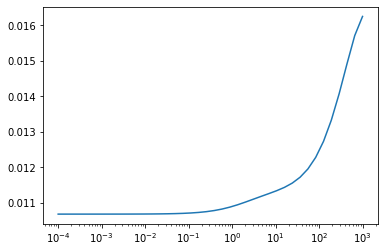

In [803]:
grid_model(Ridge(),X_tr, y_train,kfold,std.transform(X_val.values),y_val)

/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25363.130158855318, tolerance: 8.192928166031336
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21617.5967775925, tolerance: 8.18335891571368
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23438.90949715958, tolerance: 8.147031879762913
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/skl

/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1057.997136380116, tolerance: 8.305826629974597
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 612.3505413309176, tolerance: 8.192928166031336
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.09515240874316, tolerance: 8.18335891571368
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sk

R2 for test is: -0.007661306653125699
[ 0.          0.          0.          0.          0.02990086 -0.03526315
 -0.         -0.0184262  -0.06861969 -0.         -0.          0.
 -0.         -0.          0.         -0.          0.          0.
 -0.06381138 -0.10675826 -0.02747292 -0.08488042 -0.         -0.28272507
  0.          0.          0.17727048  0.01129676  0.1853129   0.
  0.          0.          0.          0.05713672  0.68940203  0.05765665]


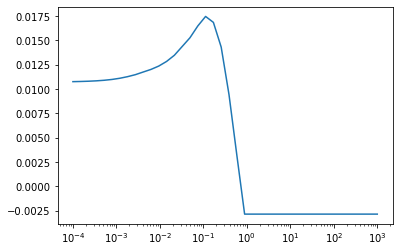

In [804]:
grid_model(Lasso(),X_tr, y_train,kfold,std.transform(X_val.values),y_val)

In [716]:
rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
rf.fit(X_tr, y_train)
y_pred = rf.predict(std.transform(X_val.values))
print("Random Forest Regression:", r2_score(y_val, y_pred))

gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
gbm.fit(X_tr, y_train)
y_pred = gbm.predict(std.transform(X_val.values))
print("Gradient Boosted Regression:", r2_score(y_val, y_pred))

Random Forest Regression: 0.021739733882140122
Gradient Boosted Regression: 0.0313985128908828


In [660]:
rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
rf.fit(X_poly_tr, y_train)
y_pred = rf.predict(poly.transform(std.transform(X_val.values)))
print("Random Forest Regression:", r2_score(y_val, y_pred))

gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
gbm.fit(X_poly_tr, y_train)
y_pred = gbm.predict(poly.transform(std.transform(X_val.values)))
print("Gradient Boosted Regression:", r2_score(y_val, y_pred))

Random Forest Regression: 0.008211224599154798
Gradient Boosted Regression: 0.03973252396175142


In [458]:
y_sq=y_train
y_train=y_saved
y_sq.describe()

count    1968.000000
mean        0.999498
std         1.419338
min         0.001058
25%         0.107252
50%         0.400114
75%         1.363119
max        15.426333
dtype: float64

In [681]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
count,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,...,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000
mean,480.644309,441.806233,414.275745,370.434282,271.960366,457.135501,378.197493,325.003726,479.532859,443.909553,...,41.557249,438.882791,443.369580,434.249322,443.331978,429.439024,403.001016,400.609079,380.054201,0.707995
std,123.989504,121.288599,125.598508,136.053365,164.355903,142.380381,139.847358,139.276101,121.841594,115.696943,...,23.696533,294.975124,293.395141,302.603570,328.889672,340.694033,351.914721,364.954993,359.288483,8.146454
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-27.000000
25%,398.000000,365.750000,340.750000,296.000000,166.000000,360.000000,288.750000,243.000000,394.750000,369.000000,...,21.000000,199.000000,200.000000,191.750000,177.000000,135.750000,127.000000,108.750000,99.000000,-5.000000
50%,470.000000,438.000000,413.500000,379.000000,289.000000,460.000000,371.000000,325.000000,467.500000,438.000000,...,42.000000,409.000000,403.000000,391.000000,379.500000,360.000000,276.000000,269.000000,250.000000,1.000000
75%,559.000000,516.250000,491.250000,454.000000,388.000000,549.000000,467.000000,411.000000,557.000000,514.000000,...,62.000000,607.250000,634.000000,614.250000,642.000000,655.000000,592.000000,617.000000,581.250000,6.000000
max,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,...,82.000000,1666.000000,1596.000000,1616.000000,1654.000000,1663.000000,1711.000000,1712.000000,1684.000000,29.000000


In [487]:
lr=Lasso()
lr.

231     1.097302
976     0.154084
135     0.652076
25      0.107252
582     0.860288
          ...   
1638    0.023264
1095    1.237800
1130    1.657737
1294    0.761352
860     0.043051
Length: 1968, dtype: float64

In [725]:

def train_and_test(lr_model,X_eval,y_eval):    

    preds = lr_model.predict(X_val)
    plt.scatter(y_eval, preds, alpha=0.2);
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    residuals = y_eval - preds
    plt.scatter(y_train_pred, lin_reg_residuals)
    
    sns.jointplot(x=preds,y=y_val, kind='reg')
    rmse = mean_squared_error(y_val, preds, squared=False)
    mae = mean_absolute_error(y_val, preds)            
    # report results
    print('\nValidation R^2 score was:{}\n RMSE: {}, MAE: {}'.format(val_score,rmse,mae))
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

def grid_model(lr,X_train, y_train,kfold,X_val,y_val):
    params = { "alpha": np.logspace(-4, 3, 40)}
    grid_est = GridSearchCV(lr, param_grid=params, cv=kfold, 
                        return_train_score=False)
             #               scoring='neg_root_mean_squared_error')
    grid_est.fit(X_train, y_train)
    df = pd.DataFrame(grid_est.cv_results_)
    
    # bring out part of the column into a new column
    df["alpha"] = df.params.apply(lambda val: val["alpha"])
    plt.semilogx(df.alpha, df.mean_test_score);    
    lr_r=grid_est.best_estimator_
    lr_r.fit(X_train, y_train)
    test_set_pred = lr_r.predict(X_val)
    print("R2 for test is:",r2_score(y_val,test_set_pred))
    print(lr_r.coef_)
    

In [233]:
frame = [data_p.iloc[:,col]+data_p.iloc[:,MAX_PY+col]+data_p.iloc[:,MAX_PY*2+col] for col in [1,2,3,4,5,6,7,8,76,77,78,79,80,81,82,83] ]
Q4=pd.concat(frame, axis=1) 

In [123]:
X4=pd.concat([Q4, data_p.iloc[:,GP_LOC:GP_LOC+9],
              data_p.iloc[:,GP_LOC+HOME_LOC:GP_LOC+HOME_LOC+9]], axis=1)

,60,61,62,63,64,65,66,67
0,73,980,407,759,573,1,175,509
1,189,551,130,1130,1302,1,81,359
2,723,325,1081,112,1122,1,56,924
3,847,520,1341,308,645,1,661,56
4,79,370,141,723,264,1,69,437
...,...,...,...,...,...,...,...,...
93,853,526,1343,314,651,1,667,62
94,85,376,147,729,270,1,75,443
95,245,440,583,421,311,1,288,227
96,378,402,38,166,494,1,107,65


In [186]:
q3=pd.concat([q5,y3d],ignore_index=True,axis=1)

In [135]:
lm=LinearRegression()

In [136]:
%whos

Variable             Type                Data/Info
--------------------------------------------------
BeautifulSoup        type                <class 'bs4.BeautifulSoup'>
ElasticNet           ABCMeta             <class 'sklearn.linear_mo<...>nate_descent.ElasticNet'>
FORMAT               str                 lxml
GP_LOC               int                 60
GridSearchCV         ABCMeta             <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
HOME_LOC             int                 75
KFold                ABCMeta             <class 'sklearn.model_selection._split.KFold'>
Lasso                ABCMeta             <class 'sklearn.linear_mo<...>oordinate_descent.Lasso'>
LinearRegression     ABCMeta             <class 'sklearn.linear_mo<...>._base.LinearRegression'>
MAX_PY               int                 15
PolynomialFeatures   type                <class 'sklearn.preproces<...>data.PolynomialFeatures'>
Q4                   DataFrame                 0     1     2     3<...>n\n[98 

In [137]:
%who

BeautifulSoup	 ElasticNet	 FORMAT	 GP_LOC	 GridSearchCV	 HOME_LOC	 KFold	 Lasso	 LinearRegression	 
MAX_PY	 PolynomialFeatures	 Q4	 Q4vt	 RATE_LIMIT	 Ridge	 SCORE_LOC	 SLEEP_TIME	 StandardScaler	 
V_LOC	 WAIT_TIME	 X4	 a	 cross_val_score	 data2	 data_p	 date	 df	 
dob	 find_box	 find_q_box	 frame	 game_data	 get	 get_response	 gp	 group1	 
i	 item	 label	 link_count	 link_wait	 links	 lm	 new_link	 np	 
page	 parse_box_score	 parse_month_sch	 parse_player	 parse_season_sch	 pd	 pickle	 players	 q4h_score	 
q4v_score	 q5	 requests	 response	 sch_filter	 sch_soup	 site_header	 sns	 test_html	 
text	 time	 today	 train_test_split	 y4d	 y4h	 y4v	 year	 


In [236]:
Q4


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1751,1658,1459,1177,1002,1201,701,997,1627,1788,1514,1361,1211,1224,632,596
1,1869,1771,1716,1237,1238,923,722,714,1632,1563,1315,1247,874,1124,1124,731
2,1706,1644,1279,845,1096,1094,908,881,1697,1830,1595,1648,1205,1202,298,460
3,1415,1607,1526,1441,1180,1379,754,774,1855,1780,1494,1209,1427,1049,390,566
4,1387,1656,1548,1185,1128,1200,1032,1052,1715,1602,1490,1617,1520,1192,886,778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,1927,1972,1655,1571,1346,598,511,517,1814,1719,1586,1886,866,1087,427,548
1260,1909,1941,1496,781,839,1118,1200,374,1911,1696,1894,1331,763,1207,959,314
1261,1885,1720,1849,1434,808,1059,712,305,2017,1943,1525,1490,1363,750,791,704
1262,1785,1973,1879,1475,940,956,898,382,1959,1847,1614,1504,1405,933,514,595


In [189]:
lm.fit(q3,y4d)

LinearRegression()

In [190]:
y4p=lm.predict(q3)

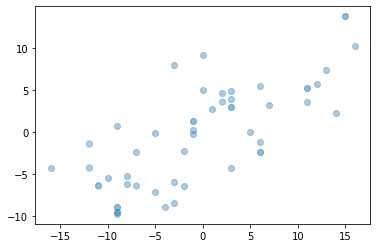

In [191]:
plt.scatter(y4d, y4p, alpha=0.2)

In [144]:
import matplotlib.pyplot as plt

In [193]:
y4resi.describe()

count    9.800000e+01
mean    -1.232574e-14
std      5.481492e+00
min     -1.170119e+01
25%     -2.714690e+00
50%     -1.995828e-02
75%      4.980955e+00
max      1.174635e+01
dtype: float64

In [192]:
y4resi=y4d-y4p

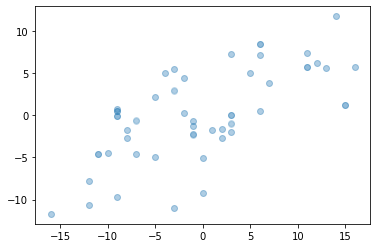

In [194]:
plt.scatter(y4d, y4resi, alpha=0.2)

In [195]:
r2_score(y4d,y4p)

0.5461069846102509

In [174]:
r2_score(y4d,y4p)

0.3804703549776157

In [151]:
from sklearn.metrics import r2_score, mean_squared_error

In [187]:
half=pd.concat([y4d,q3],axis=1,ignore_index=True)

In [197]:
lm.coef_

array([ 2.70786650e-02, -2.11548739e-03, -8.35561001e-03,  9.37823878e-03,
        1.15407417e-03, -6.18712078e-03, -2.77028024e-03,  2.88292939e-02,
        3.90835178e-03, -7.99895029e-03,  2.90405750e-02, -1.33177838e-02,
       -4.84972628e-03, -7.28632269e-03,  3.76471631e-03,  7.46653038e-04,
       -4.72238121e-03, -2.80191365e-03,  1.46416480e-03,  1.26575388e-02,
       -3.01656923e-04, -4.40540433e-01,  2.24837437e-03, -5.77931764e-04,
       -3.24351550e-03, -2.24426647e-01])

In [284]:
len(game_data)

1230

In [270]:
playoff_data=game_data[1230:]

In [285]:
len(playoff_data)

79

In [272]:
playoff_data[0]

{'home': 'CLE',
 'visit': 'TOR',
 'date': Timestamp('2017-05-01 00:00:00'),
 'player_v': ['lowryky01',
  'derozde01',
  'ibakase01',
  'valanjo01',
  'carrode01',
  'tuckepj01',
  'pattepa01',
  'powelno01',
  'josepco01',
  'wrighde01',
  'vanvlfr01',
  'poeltja01',
  'siakapa01',
  13,
  14],
 'player_h': ['jamesle01',
  'thomptr01',
  'irvinky01',
  'loveke01',
  'smithjr01',
  'shumpim01',
  'willide01',
  'korveky01',
  'fryech01',
  'willide02',
  'jonesda02',
  'jonesja02',
  12,
  13,
  14],
 'data': [18,
  566,
  720,
  533,
  566,
  379,
  273,
  341,
  68,
  154,
  0,
  0,
  0,
  0,
  0,
  30,
  720,
  415,
  535,
  221,
  174,
  546,
  379,
  305,
  305,
  0,
  0,
  0,
  0,
  0,
  26,
  576,
  720,
  632,
  452,
  364,
  212,
  356,
  144,
  144,
  0,
  0,
  0,
  0,
  0,
  31,
  522,
  241,
  249,
  0,
  0,
  522,
  273,
  720,
  0,
  479,
  198,
  198,
  198,
  0,
  1,
  835,
  627,
  693,
  387,
  498,
  419,
  645,
  144,
  426,
  100,
  38,
  55,
  56,
  0,
  30,
  588,

In [281]:
len(game_data)

1230

In [275]:
game_data[1229]

{'home': 'POR',
 'visit': 'NOP',
 'date': Timestamp('2017-04-12 00:00:00'),
 'player_v': ['hillso01',
  'fraziti01',
  'ajincal01',
  'cunnida01',
  'holidjr01',
  'diallch01',
  'crawfjo02',
  'toupaax01',
  'cookqu01',
  'motiedo01',
  'mooreet01',
  11,
  12,
  13,
  14],
 'player_h': ['vonleno01',
  'laymaja01',
  'leoname01',
  'napiesh01',
  'turneev01',
  'connapa01',
  'harklma01',
  'quartti01',
  8,
  9,
  10,
  11,
  12,
  13,
  14],
 'data': [22,
  720,
  365,
  365,
  569,
  524,
  151,
  0,
  0,
  196,
  355,
  355,
  0,
  0,
  0,
  31,
  0,
  576,
  538,
  0,
  0,
  720,
  638,
  538,
  226,
  182,
  182,
  0,
  0,
  0,
  25,
  720,
  682,
  433,
  557,
  433,
  163,
  0,
  0,
  38,
  287,
  287,
  0,
  0,
  0,
  25,
  369,
  0,
  174,
  0,
  0,
  715,
  720,
  715,
  720,
  187,
  0,
  0,
  0,
  0,
  82,
  257,
  191,
  330,
  672,
  525,
  17,
  499,
  33,
  42,
  288,
  392,
  0,
  0,
  0,
  30,
  519,
  524,
  624,
  524,
  561,
  355,
  297,
  196,
  0,
  0,
  0,
  

In [415]:
type(lr_p.coef_)

numpy.ndarray

In [417]:
lr_p.coef_[lr_p.coef_ >1]

array([ 7.64375087,  1.61192819,  3.6825788 ,  4.15674038,  4.02445963,
        3.63563794,  3.2810693 ,  1.50870872,  1.36689144,  1.72474903,
        2.83873662,  3.16772738,  2.49726995,  5.26735344,  2.10585646,
       33.66581345,  4.5808546 ,  4.87127988,  4.1993784 ,  3.37700101,
        3.82908919,  6.80831043,  6.01311049,  4.15858458,  6.67960065])

In [418]:
lr_p.coef_[17]

7.643750868161564

In [419]:
lr_p.coef_[25]

-7.7031849132635655

In [420]:
lr_p.coef_[lr_p.coef_ <-1]

array([ -7.70318491,  -1.56306183,  -3.34009794,  -4.01679357,
        -3.75298082,  -3.36219436,  -3.29891167,  -1.11070603,
        -1.76053072,  -2.40200449,  -3.52909484,  -2.23562862,
        -5.28096013, -18.61571384,  -2.99863923,  -3.93691527,
        -6.65037115,  -5.74478831,  -4.22818351,  -6.67007983,
        -1.82886231, -14.86445632,  -4.32095502,  -4.96454486,
        -4.17453382])

In [422]:
lr_p.coef_.argmax()

450

In [423]:
lr_p.coef_[450]

33.665813451920855

In [430]:
lr_p.get_feature_names_

AttributeError: 'LinearRegression' object has no attribute 'get_feature_names_'

In [433]:
poly.get_feature_names()[450]

'x16 x24'

In [491]:
len(players)

745

In [492]:
len(playoff_data)

243

In [493]:
len(game_data)

3690

In [494]:
game_data[-1]

{'home': 'POR',
 'visit': 'SAC',
 'date': Timestamp('2019-04-10 00:00:00'),
 'player_v': ['caulewi01',
  'foxde01',
  'hieldbu01',
  'barneha02',
  'bjeline01',
  'baglema01',
  'ferreyo01',
  'bogdabo01',
  'breweco01',
  'masonfr01',
  'swanica01',
  'willitr02',
  'johnsbj01',
  13,
  14],
 'player_h': ['simonan01',
  'trentga02',
  'laymaja01',
  'leoname01',
  'labissk01',
  'colliza01',
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14],
 'data': [39,
  520,
  566,
  520,
  581,
  676,
  200,
  154,
  200,
  139,
  0,
  44,
  0,
  0,
  0,
  48,
  520,
  437,
  447,
  361,
  39,
  681,
  283,
  359,
  273,
  0,
  200,
  0,
  0,
  0,
  26,
  0,
  0,
  0,
  0,
  0,
  604,
  720,
  720,
  364,
  356,
  421,
  415,
  0,
  0,
  18,
  0,
  0,
  0,
  0,
  0,
  330,
  562,
  357,
  631,
  720,
  390,
  247,
  363,
  0,
  82,
  295,
  154,
  244,
  604,
  274,
  62,
  199,
  148,
  1010,
  90,
  49,
  76,
  21,
  0,
  30,
  720,
  720,
  720,
  636,
  604,
  200,
  0,
  0,
  0,
  0,
  0,
  

In [495]:
playoff_data[-1]

{'home': 'GSW',
 'visit': 'TOR',
 'date': Timestamp('2019-06-13 00:00:00'),
 'player_v': ['siakapa01',
  'lowryky01',
  'leonaka01',
  'gasolma01',
  'greenda02',
  'vanvlfr01',
  'ibakase01',
  'powelno01',
  8,
  9,
  10,
  11,
  12,
  13,
  14],
 'player_h': ['greendr01',
  'curryst01',
  'iguodan01',
  'thompkl01',
  'looneke01',
  'couside01',
  'livinsh01',
  'cookqu01',
  'mckinal01',
  'bogutan01',
  'jerebjo01',
  11,
  12,
  13,
  14],
 'data': [33,
  610,
  583,
  720,
  523,
  394,
  326,
  247,
  197,
  0,
  0,
  0,
  0,
  0,
  0,
  27,
  720,
  720,
  492,
  252,
  286,
  434,
  468,
  228,
  0,
  0,
  0,
  0,
  0,
  0,
  26,
  720,
  479,
  720,
  445,
  374,
  548,
  275,
  38,
  0,
  0,
  0,
  0,
  0,
  0,
  28,
  720,
  720,
  533,
  374,
  8,
  720,
  337,
  187,
  0,
  0,
  0,
  0,
  0,
  0,
  6,
  252,
  1019,
  578,
  878,
  744,
  214,
  886,
  311,
  0,
  0,
  0,
  0,
  0,
  0,
  32,
  720,
  720,
  478,
  618,
  311,
  238,
  0,
  101,
  242,
  170,
  0,
  0,
 

In [505]:
X_poly_tr.describe()

,0,1,2,3,4,5,6,7,8,9,...,694,695,696,697,698,699,700,701,702,0
count,1968.0,1.968000e+03,1.968000e+03,1.968000e+03,1.968000e+03,1.968000e+03,1.968000e+03,1.968000e+03,1.968000e+03,1.968000e+03,...,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000
mean,1.0,2.256551e-16,-1.769136e-16,-6.814784e-17,-1.570559e-16,-3.249433e-17,-4.874150e-17,2.229472e-16,3.059883e-16,-3.800032e-16,...,0.151360,0.014980,0.023602,1.000000,0.067383,0.053415,1.000000,-0.074379,1.000000,0.999498
std,0.0,1.000254e+00,1.000254e+00,1.000254e+00,1.000254e+00,1.000254e+00,1.000254e+00,1.000254e+00,1.000254e+00,1.000254e+00,...,1.057943,1.012880,1.000825,1.530190,0.983010,0.976838,1.392996,0.970777,1.362897,1.419338
min,1.0,-5.902930e+00,-4.751254e+00,-4.396343e+00,-4.433920e+00,-3.456507e+00,-4.498549e+00,-3.940408e+00,-3.417267e+00,-4.756712e+00,...,-3.634891,-7.026313,-6.722299,0.000001,-7.738385,-4.965899,0.000950,-6.174656,0.001988,0.001058
25%,1.0,-5.918797e-01,-5.743390e-01,-6.028636e-01,-5.806322e-01,-6.675745e-01,-6.726791e-01,-6.548208e-01,-6.318213e-01,-5.957610e-01,...,-0.350880,-0.415116,-0.382391,0.202325,-0.383488,-0.395872,0.120274,-0.466625,0.111703,0.107252
50%,1.0,6.027809e-02,9.738704e-02,8.621412e-02,7.511375e-02,1.306887e-01,4.960177e-03,-3.202092e-02,-2.572892e-02,5.298947e-02,...,0.116487,0.005058,0.013510,0.591223,0.031605,0.017705,0.435894,-0.018090,0.456904,0.400114
75%,1.0,6.753566e-01,6.795496e-01,6.900451e-01,6.871433e-01,7.044405e-01,6.886363e-01,6.368534e-01,6.706326e-01,6.480502e-01,...,0.585995,0.444418,0.451850,0.996745,0.473756,0.446028,1.354284,0.332839,1.394832,1.363119
max,1.0,3.109497e+00,3.008200e+00,2.949083e+00,3.603651e+00,3.433503e+00,3.367500e+00,3.266276e+00,3.011181e+00,3.350431e+00,...,7.489955,5.945282,6.244087,12.226163,7.247754,6.508575,11.761825,6.169167,11.073145,15.426333


In [508]:
X_tr[:,0]

array([-0.57224948, -0.14474809,  0.78005084, ..., -0.99975088,
        0.14316101, -0.07495195])